In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np

from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score, confusion_matrix

import pickle



/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("genetic_EDA.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59392 entries, 0 to 59391
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CHROM                    59392 non-null  object 
 1   AF_ESP                   59392 non-null  float64
 2   CLNVC                    59392 non-null  object 
 3   CLASS                    59392 non-null  int64  
 4   IMPACT                   59392 non-null  object 
 5   SYMBOL                   59392 non-null  object 
 6   LoFtool                  59392 non-null  float64
 7   CADD_PHRED               59392 non-null  float64
 8   2KB_upstream_variant     59392 non-null  float64
 9   3_prime_UTR_variant      59392 non-null  float64
 10  500B_downstream_variant  59392 non-null  float64
 11  5_prime_UTR_variant      59392 non-null  float64
 12  frameshift_variant       59392 non-null  float64
 13  intron_variant           59392 non-null  float64
 14  missense_variant      

In [4]:
df.CHROM

0        other_chrom
1        other_chrom
2        other_chrom
3        other_chrom
4        other_chrom
            ...     
59387    other_chrom
59388    other_chrom
59389    other_chrom
59390    other_chrom
59391    other_chrom
Name: CHROM, Length: 59392, dtype: object

In [5]:
df_dummies_chrom = pd.get_dummies(df['CHROM'],drop_first=True)
df_dummies_clnvc = pd.get_dummies(df['CLNVC'],drop_first=True)
df_dummies_impact = pd.get_dummies(df['IMPACT'],drop_first=True)
df_dummies_symbol = pd.get_dummies(df['SYMBOL'],drop_first=True)
df_temp = df.drop(["CHROM", "CLNVC", "IMPACT", "SYMBOL"], axis =1 )

In [6]:
df_all = pd.concat([df_temp, df_dummies_chrom, df_dummies_clnvc, df_dummies_impact, df_dummies_symbol], axis = 1)

In [7]:
df_all.columns

Index(['AF_ESP', 'CLASS', 'LoFtool', 'CADD_PHRED', '2KB_upstream_variant',
       '3_prime_UTR_variant', '500B_downstream_variant', '5_prime_UTR_variant',
       'frameshift_variant', 'intron_variant', 'missense_variant', 'nonsense',
       'splice_acceptor_variant', 'splice_donor_variant', 'synonymous_variant',
       'other_chrom', 'Duplication', 'Indel', 'Insertion', 'Inversion',
       'Microsatellite', 'single_nucleotide_variant', 'LOW', 'MODERATE',
       'MODIFIER', 'ATM', 'BARD1', 'BRCA1', 'BRCA2', 'BRIP1', 'CDH1', 'CHEK2',
       'DICER1', 'DMD', 'FBN1', 'LDLR', 'MLH1', 'MSH2', 'MSH6', 'MUTYH',
       'MYBPC3', 'MYH7', 'NBN', 'NEB', 'NF1', 'PALB2', 'PLEC', 'PMS2', 'POLD1',
       'POLE', 'RAD50', 'RYR1', 'RYR2', 'SCN5A', 'SMARCA4', 'STK11', 'SYNE1',
       'TP53', 'TSC2', 'TTN', 'other-gene'],
      dtype='object')

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
df_all_X = df_all.drop(["CLASS"], axis =1)
std.fit(df_all_X.values)
df_all_X_std = std.transform(df_all_X.values)

df_all_X_std = pd.DataFrame(df_all_X_std)

df_all = pd.concat([df_all_X_std, df_all.CLASS], axis = 1)

df_all.columns =['AF_ESP', 'LoFtool', 'CADD_PHRED', '2KB_upstream_variant',
       '3_prime_UTR_variant', '500B_downstream_variant', '5_prime_UTR_variant',
       'frameshift_variant', 'intron_variant', 'missense_variant', 'nonsense',
       'splice_acceptor_variant', 'splice_donor_variant', 'synonymous_variant',
       'other_chrom', 'Duplication', 'Indel', 'Insertion', 'Inversion',
       'Microsatellite', 'single_nucleotide_variant', 'LOW', 'MODERATE',
       'MODIFIER', 'ATM', 'BARD1', 'BRCA1', 'BRCA2', 'BRIP1', 'CDH1', 'CHEK2',
       'DICER1', 'DMD', 'FBN1', 'LDLR', 'MLH1', 'MSH2', 'MSH6', 'MUTYH',
       'MYBPC3', 'MYH7', 'NBN', 'NEB', 'NF1', 'PALB2', 'PLEC', 'PMS2', 'POLD1',
       'POLE', 'RAD50', 'RYR1', 'RYR2', 'SCN5A', 'SMARCA4', 'STK11', 'SYNE1',
       'TP53', 'TSC2', 'TTN', 'other-gene', 'CLASS']

In [9]:
df_all.head()

,AF_ESP,LoFtool,CADD_PHRED,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,...,RYR2,SCN5A,SMARCA4,STK11,SYNE1,TP53,TSC2,TTN,other-gene,CLASS
0,-0.252343,-0.676789,-1.437014,-0.086095,-0.110231,-0.023933,-0.186966,-0.139141,-0.492506,0.965831,...,-0.073369,-0.070893,-0.086492,-0.076438,-0.084392,-0.083477,-0.103211,-0.218783,0.796767,0
1,2.364400,-0.676789,0.662147,-0.086095,-0.110231,-0.023933,-0.186966,-0.139141,-0.492506,0.965831,...,-0.073369,-0.070893,-0.086492,-0.076438,-0.084392,-0.083477,-0.103211,-0.218783,0.796767,0
2,-0.252343,-0.676789,-0.408216,-0.086095,-0.110231,-0.023933,-0.186966,-0.139141,-0.492506,0.965831,...,-0.073369,-0.070893,-0.086492,-0.076438,-0.084392,-0.083477,-0.103211,-0.218783,0.796767,1
3,-0.175026,-0.898177,0.579387,-0.086095,-0.110231,-0.023933,-0.186966,-0.139141,-0.492506,0.965831,...,-0.073369,-0.070893,-0.086492,-0.076438,-0.084392,-0.083477,-0.103211,-0.218783,0.796767,0
4,-0.219698,-0.898177,0.947209,-0.086095,-0.110231,-0.023933,-0.186966,-0.139141,-0.492506,0.965831,...,-0.073369,-0.070893,-0.086492,-0.076438,-0.084392,-0.083477,-0.103211,-0.218783,0.796767,1


In [10]:
df_all.to_csv("genetic_EDA_st.csv")

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df_all.drop(["CLASS"], axis =1), 
                                                    df_all.CLASS,
                                                   test_size =0.3,
                                                   random_state = 41)

In [12]:
#X_train, X_test, Y_train, Y_test = train_test_split(df.drop("CLASS", axis =1), 
#                                                    df.CLASS,
#                                                   test_size =0.3,
#                                                   random_state = 41)

In [13]:
logit = LogisticRegression()
#logit.fit(X_train, Y_train)
#print("Training: {:.2f}%".format(100*logit.score(X_train_d, Y_train_d)))
#print("Testing: {:.2f}%".format(100*logit.score(X_test_d, Y_test_d)))

In [14]:
# logic
C_range = np.arange(100,1000,50)
param_grid = dict(C = C_range)
gridlogit = GridSearchCV(logit, param_grid, cv=2, scoring='accuracy')
gridlogit.fit(X_train, Y_train)

print(gridlogit.best_params_)
print(gridlogit.best_estimator_)
print(gridlogit.best_score_)

{'C': 100}
LogisticRegression(C=100)
0.7469812863809111


In [15]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
et = ExtraTreesClassifier()
gbm = xgb.XGBClassifier

In [16]:
# knn
#k_range = list(range(1,20))
k_range = list(range(18,19))
param_grid = dict(n_neighbors = k_range)
gridknn = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
gridknn.fit(X_train, Y_train)

print(gridknn.best_params_)
print(gridknn.best_estimator_)
print(gridknn.best_score_)

{'n_neighbors': 18}
KNeighborsClassifier(n_neighbors=18)
0.7385625631404242


In [17]:
# rf
#nest = np.arange(100,300,50)
nest = np.arange(120,180,10)
param_grid = dict(n_estimators = nest)
gridrf = GridSearchCV(rf, param_grid, cv=2, scoring='accuracy')
gridrf.fit(X_train, Y_train)
print(gridrf.best_params_)
print(gridrf.best_estimator_)
print(gridrf.best_score_)


{'n_estimators': 130}
RandomForestClassifier(n_estimators=130)
0.714605282147496


In [33]:
# et
#nest = np.arange(1,100,20)
#nest = np.arange(50,100,10)
param_grid = dict(n_estimators = nest)
gridex = GridSearchCV(et, param_grid, cv=2, scoring='accuracy')
gridex.fit(X_train, Y_train)
print(gridex.best_params_)
print(gridex.best_estimator_)
print(gridex.best_score_)


NameError: name 'X_train_d' is not defined

In [18]:
gbm = xgb.XGBClassifier( 
                        n_estimators=300,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )



In [19]:
model = gbm.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
pickle.dump(model, open('xgb.pickle', 'wb'))


In [20]:
pickle.dump(gridlogit.best_estimator_, open('logit.pickle', 'wb'))
pickle.dump(gridknn.best_estimator_, open('knn.pickle', 'wb'))
pickle.dump(gridrf.best_estimator_, open('rf.pickle', 'wb'))

Text(0.5, 0, 'Xgboost Feature Importance')

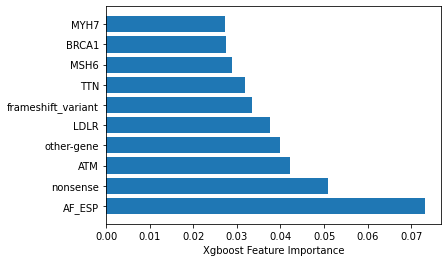

In [52]:
import matplotlib.pyplot as plt
sorted_idx = model.feature_importances_.argsort()[::-1]
plt.barh(X_train.columns[sorted_idx][:10], model.feature_importances_[sorted_idx][:10])
plt.xlabel("Xgboost Feature Importance")

In [53]:
from sklearn.metrics import confusion_matrix

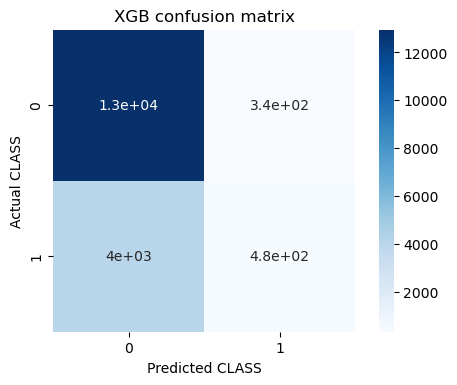

In [57]:
xgb_confusion = confusion_matrix(Y_test, gbm.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted CLASS')
plt.ylabel('Actual CLASS')
plt.title('XGB confusion matrix');